# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Background and Methodology

Suppose, we are the data team of a popular digital music service similar to Spotify or Pandora. The users stream their favorite songs either using the free tier that place advertisements between songs or use the premium plan for which they pay a monthly fee without any advertisements between songs. Users can upgrade, downgrade or altogether cancel their services. The dataset given to us contains a log of the activities of each user on the service whether they are playing songs, logging out, upgrading their service or cancelling it. All this data contains key insights in keeping the users of the service happy. Our task in this project is to develop a model that predict which users are at risk. If we can identify users that are at risk to churn either by downgrading from premium or by cancelling their service, the business can offer them incentives and discounts potentially saving millions in revenues.

To tackle this project, we are given a subset of the dataset that contains a log of events mentioned below. The events include:

Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Conf...
About
Submit Registration
Settings
Login
Register
Add to Playlist
Add Friend
NextSong
Thumbs Up
Help
Upgrade
To solve this problem, first we load the dataset into Apache Spark and delete any rows that have missing userIds or sessionIds. Then we calculate the below mentioned metrics from the given data for each user.

Number of Songs
Number of sessions
Number of artists

The label which needs to be predicted is churn which is defined by a user who has performed either a "Submit Downgrade" event or "Cancellation Confirmation" event.

After the above features are calculated, we build the model using the following three algorithms:

Logistic Regression
Random Forest Classifier
SVM Classifier 

The dataset is split into training and testing sets. A machine learning pipeline is built in which we first convert each row into a single feature vector. Then data in each of the column is normalized and is fed into each of the above classifiers.

Metrics
The models are evaluated using the F1 score since we have a small number of churned users. F1 score is a better measure to use when there is an uneven class distribution.

In [1]:
#import packages
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf,max,avg,col,when
from pyspark.sql.types import IntegerType

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("appname")\
    .config("config option","config value")\
    .getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.driver.host', '6bb05fc88dc2'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('config option', 'config value'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '42469'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1575895187364'),
 ('spark.app.name', 'appname'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#load dataset
path = "mini_sparkify_event_data.json"
spd = spark.read.json(path)
spd.printSchema

<bound method DataFrame.printSchema of DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]>

In [4]:
# convert to a dataframe
df = spd.toPandas()
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
#check for Nulls
df.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [6]:
#drop NA's
df_valid = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [7]:
df_valid.drop_duplicates()
# drop empty strings
df_valid = df_valid.filter(df_valid["userId"] != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
#Churn is defined as the users who got to 'Cancellation Confirmation'. Also 'Downgrade' event is being tracked. 
churn_flag = udf(lambda x:1 if x=="Cancellation Confirmation" else 0, IntegerType())
spd = spd.withColumn("churn_flag",churn_flag("page"))


# label Churned users (if Churned once)
windowval = Window.partitionBy('userId')
spd = spd.withColumn('churn', max('churn_flag').over(windowval))


#Downgrade Event
down_flag = udf(lambda x:1 if x=="Submit Downgrade" else 0, IntegerType())
spd = spd.withColumn("Downgrade_flag", down_flag("page"))


# label Downgraded users (if Downgraded  once)
windowval = Window.partitionBy('userId')
spd = spd.withColumn('Downgraded', max('Downgrade_flag').over(windowval))

#Drop the flag columns (no longer needed)
columns_to_drop = ['churn_flag', 'Downgrade_flag']
spd = spd.drop(*columns_to_drop)

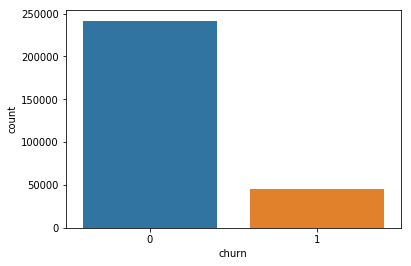

In [9]:
churn_count = spd.select(['churn']).toPandas()
sns.countplot(churn_count['churn']);

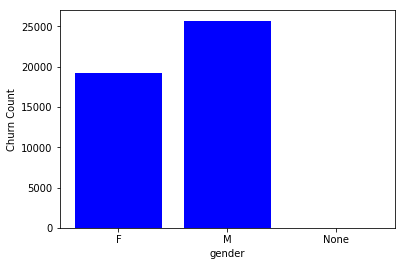

In [10]:
def plot_df_churns(groupField):
    plot_df = spd.groupby(groupField).agg({'churn':'sum'}).toPandas()
    
    #plotting
    plt.bar(x=plot_df[groupField],height=plot_df['sum(churn)'],color=['blue','orange'])
    plt.xlabel(groupField)
    plt.ylabel("Churn Count")
    plt.show()
    
#Users Churn by Gender
plot_df_churns('gender')

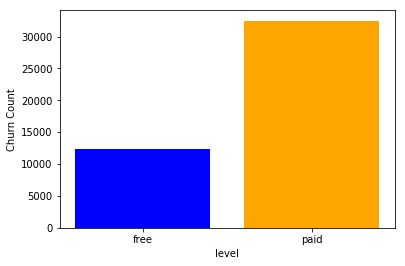

In [11]:
#Users churn by Level
plot_df_churns('level')

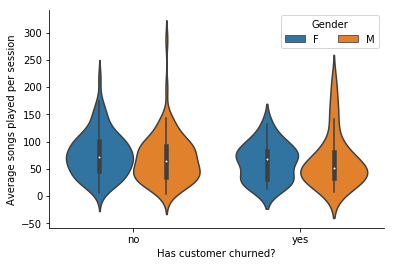

In [12]:
songs_pd = spd.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

Value_map = {1:'yes', 0:'no'}
songs_pd['churn'] = songs_pd['churn'].map(Value_map)

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songs_pd)
plt.xlabel('Has customer churned?')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
sns.despine(ax=ax);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [13]:
#First obvious features would be Gender and Level, apart from downgrade event

#gender
gender = spd.select("userId", "gender").dropDuplicates()
gender = gender.replace(["M", "F"], ["0", "1"], "gender")
gender = gender.select("userId", gender.gender.cast("int"))

gender.show(5)

#level
level = spd.select("userId", "level").dropDuplicates()
level = level.replace(["free", "paid"], ["0", "1"], "level")
level = level.select("userId", level.level.cast("int"))

level.show(5)

#users downgrade
downgrade = spd.select("userId", "Downgraded").dropDuplicates()
downgrade = downgrade.select("userId", downgrade.Downgraded.cast("int"))

downgrade.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
|     6|    0|
|300022|    1|
+------+-----+
only showing top 5 rows

+------+----------+
|userId|Downgraded|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         0|
|   124|         0|
|    51|         0|
+------+----------+
only showing top 5 rows



In [14]:
#Number of Song Played as a feature 
song_played = spd.where(spd.song!='null').groupby('userId') \
    .agg({'song':'count'}).orderBy('userId') \
    .select(['userId','count(song)'])
song_played.withColumnRenamed("count(song)", "songCount")
song_played.show()

+------+-----------+
|userId|count(song)|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [15]:
#Number of Singers user has listened to 
singers_count = spd.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg({'artist':'count'}).orderBy('userId') \
    .select(['userId','count(artist)'])
singers_count.withColumnRenamed("count(artist)", "artistCount")
singers_count.show()

+------+-------------+
|userId|count(artist)|
+------+-------------+
|      |            0|
|    10|          565|
|   100|         1705|
|100001|          125|
|100002|          184|
|100003|           50|
|100004|          733|
|100005|          149|
|100006|           26|
|100007|          357|
|100008|          623|
|100009|          442|
|100010|          252|
|100011|           11|
|100012|          397|
|100013|          826|
|100014|          233|
|100015|          627|
|100016|          431|
|100017|           51|
+------+-------------+
only showing top 20 rows



In [16]:
#number of sessions 
session_count = spd.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
session_count = session_count.withColumnRenamed("count", "sessionCount")

session_count.show(5)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



In [17]:
#combine features & label
spd_modelFeatures = spd.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in [gender, level, downgrade, singers_count, session_count, song_played]:
    spd_modelFeatures = spd_modelFeatures.join(feature,'userId')

spd_modelFeatures = spd_modelFeatures.withColumnRenamed("count(song)", "songCount").withColumnRenamed(\
                                                        "count(artist)", "artistCount")

spd_modelFeatures.show(5)

+------+-----+------+-----+----------+-----------+------------+---------+
|userId|churn|gender|level|Downgraded|artistCount|sessionCount|songCount|
+------+-----+------+-----+----------+-----------+------------+---------+
|100010|    0|     1|    0|         0|        252|           7|      275|
|200002|    0|     0|    0|         0|        339|           6|      387|
|200002|    0|     0|    1|         0|        339|           6|      387|
|   125|    1|     0|    0|         0|          8|           1|        8|
|   124|    0|     1|    1|         0|       2232|          29|     4079|
+------+-----+------+-----+----------+-----------+------------+---------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [18]:
assembler = VectorAssembler(inputCols=spd_modelFeatures.columns[2:],outputCol='featureVector')
scaler = StandardScaler(inputCol="featureVector", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

In [19]:
lr =  LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.0, elasticNetParam=0)

#defining Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, lr])

#Parameter grid
param = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.001, 0.01, 0.1]) \
    .build()

#set evaluator -'one time needed'
evaluator = MulticlassClassificationEvaluator(metricName='f1')

#cross-validation
lr_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, 
                             evaluator=evaluator, numFolds=3)

In [20]:
#Random forest
rf = RandomForestClassifier(numTrees=20, maxDepth=2, labelCol="label", seed=42)

#defining Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, rf])

#Parameter grid
param = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50]).addGrid(rf.maxDepth,[2,3, 5]) \
    .build()


#cross-validation
rf_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, 
                             evaluator=evaluator, numFolds=3)

In [21]:
# SVM
svm = LinearSVC(labelCol="label", featuresCol="features",maxIter=10)

#defining Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, svm])

#Parameter grid
param = ParamGridBuilder() \
    .build()


#cross-validation
svm_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, 
                              evaluator=evaluator, numFolds=3)

In [22]:
#Split the data into train and test subsets
train, test = spd_modelFeatures.randomSplit([0.7, 0.3], seed=42)

In [23]:
# Function for evaluation of each model
def evaluation(model,modelname):
    """
    Input:
      model- model for evaluation 
      modelname - string representing the name of the model used
    Return:
      None
    """
    #training
    cv = model.fit(train)
    #evaluation
    print(modelname)
    print("\nTraining Metrics: ",cv.avgMetrics)
    # test performance
    predictions = cv.transform(test)
    print("\nTest Metric 'F1-Score': ",MulticlassClassificationEvaluator().setMetricName("f1").evaluate(predictions))
    return cv

In [42]:
#Evaluation for Logistic Regression
cv_lr = evaluation(lr_crossval, "Logistic Regression")

Logistic Regression

Training Metrics:  [0.6799295545398909, 0.6799295545398909, 0.6799295545398909, 0.6799295545398909]

Test Metric 'F1-Score':  0.6670274170274171


In [24]:
#Evaluation for Random Forest Classifier
cv_rf = evaluation(rf_crossval, "Random Forest Classifier")

Random Forest Classifier

Training Metrics:  [0.6741924063429355, 0.6741924063429355, 0.7052444589743515, 0.6804760155335214, 0.6804760155335214, 0.7104974319223429]

Test Metric 'F1-Score':  0.7069970845481051


In [26]:
#Evaluation of SVM classifier
cv_svm = evaluation(svm_crossval, "SVM Classifier")

SVM Classifier

Training Metrics:  [0.6761055777925308]

Test Metric 'F1-Score':  0.6670274170274171


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Summary

Random Forest Classifier gives us the best F1 scores among the methods under consideration